In [1]:
"""
Pancreas Classification: Fatty Infiltration Analysis
Using Clinical Thresholds:
- Normal: > 40 HU
- Mild Fatty: 30-40 HU
- Moderate Fatty: 10-29 HU
- Severe Fatty: < 10 HU

Plus Pancreas-to-Spleen Ratio (≤0.7 = Fatty)
"""

import os
import numpy as np
import nibabel as nib
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import joblib

In [3]:
# ============================================================================
# CONFIGURATION
# ============================================================================
BASE_PATH = "/kaggle/input/pancreatic-cancer"
IMG_TR_PATH = os.path.join(BASE_PATH, "Task07_Pancreas/imagesTr")
LBL_TR_PATH = os.path.join(BASE_PATH, "Task07_Pancreas/labelsTr")
IMG_TS_PATH = os.path.join(BASE_PATH, "Task07_Pancreas/imagesTs")

HU_CLIP = (-200, 200)
RANDOM_STATE = 42

# Clinical Thresholds
THRESHOLDS = {
    'severe': 10,      # < 10 HU
    'moderate': 29,    # 10-29 HU
    'mild': 40,        # 30-40 HU
    # > 40 HU = normal
}

SPLEEN_RATIO_THRESHOLD = 0.7  # ≤ 0.7 indicates fatty pancreas

In [4]:
# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def find_nii_files(directory):
    """Find all .nii and .nii.gz files and return sorted list"""
    nii_gz = sorted(glob(os.path.join(directory, "*.nii.gz")))
    nii = sorted(glob(os.path.join(directory, "*.nii")))
    
    all_files = []
    for f in nii_gz + nii:
        basename = os.path.basename(f).replace('.nii.gz', '').replace('.nii', '')
        all_files.append((basename, f))
    
    all_files.sort(key=lambda x: x[0])
    return [f for _, f in all_files]

In [5]:
def classify_fatty_category(mean_hu):
    """
    Classify pancreas based on clinical HU thresholds
    
    Returns:
    --------
    str : Category name
    int : Numeric label (0=Normal, 1=Mild, 2=Moderate, 3=Severe)
    """
    if mean_hu > THRESHOLDS['mild']:
        return 'Normal', 0
    elif THRESHOLDS['moderate'] < mean_hu <= THRESHOLDS['mild']:
        return 'Mild Fatty', 1
    elif THRESHOLDS['severe'] <= mean_hu <= THRESHOLDS['moderate']:
        return 'Moderate Fatty', 2
    else:  # < 10 HU
        return 'Severe Fatty', 3

In [6]:
def compute_pancreas_features(image_path, mask_path, hu_clip=HU_CLIP, verbose=False):
    """
    Compute comprehensive pancreas features including HU stats and volume
    
    Returns:
    --------
    dict : Dictionary of features or None if error
    """
    try:
        img_nii = nib.load(image_path)
        mask_nii = nib.load(mask_path)
        
        img_data = img_nii.get_fdata().astype(np.float32)
        mask_data = mask_nii.get_fdata()
        
        if verbose:
            print(f"\n--- {os.path.basename(image_path)} ---")
            print(f"Image shape: {img_data.shape}")
            print(f"Mask unique values: {np.unique(mask_data)}")
        
        if img_data.shape != mask_data.shape:
            if verbose:
                print("Shape mismatch!")
            return None
        
        # Pancreas mask (label >= 1)
        pancreas_mask = (mask_data >= 1).astype(bool)
        pancreas_voxels = np.sum(pancreas_mask)
        
        if pancreas_voxels == 0:
            if verbose:
                print("Empty pancreas mask!")
            return None
        
        # Extract pancreas HU values
        pancreas_hu = img_data[pancreas_mask]
        pancreas_hu = np.clip(pancreas_hu, hu_clip[0], hu_clip[1])
        
        # Try to find spleen (if mask has label 2, otherwise approximate)
        spleen_mask = (mask_data == 2).astype(bool)
        spleen_hu_mean = None
        pancreas_spleen_ratio = None
        
        if np.sum(spleen_mask) > 0:
            spleen_hu = img_data[spleen_mask]
            spleen_hu = np.clip(spleen_hu, hu_clip[0], hu_clip[1])
            spleen_hu_mean = np.mean(spleen_hu)
            
            # Calculate pancreas-to-spleen ratio
            pancreas_spleen_ratio = np.mean(pancreas_hu) / spleen_hu_mean if spleen_hu_mean != 0 else None
            
            if verbose:
                print(f"Spleen found: mean HU = {spleen_hu_mean:.1f}")
                print(f"Pancreas/Spleen ratio: {pancreas_spleen_ratio:.3f}")
        
        # Get voxel spacing for volume
        pixdim = img_nii.header['pixdim'][1:4]
        voxel_volume = np.prod(pixdim)  # mm³
        
        features = {
            'mean_hu': np.mean(pancreas_hu),
            'std_hu': np.std(pancreas_hu),
            'min_hu': np.min(pancreas_hu),
            'max_hu': np.max(pancreas_hu),
            'median_hu': np.median(pancreas_hu),
            'q10_hu': np.percentile(pancreas_hu, 10),
            'q25_hu': np.percentile(pancreas_hu, 25),
            'q75_hu': np.percentile(pancreas_hu, 75),
            'q90_hu': np.percentile(pancreas_hu, 90),
            'volume_mm3': pancreas_voxels * voxel_volume,
            'num_voxels': pancreas_voxels,
            'spleen_mean_hu': spleen_hu_mean,
            'pancreas_spleen_ratio': pancreas_spleen_ratio
        }
        
        if verbose:
            print(f"Pancreas mean HU: {features['mean_hu']:.1f}")
            print(f"Volume: {features['volume_mm3']:.0f} mm³")
        
        return features
        
    except Exception as e:
        if verbose:
            print(f"Error: {e}")
        return None

In [7]:
# ============================================================================
# DATA LOADING AND FEATURE EXTRACTION
# ============================================================================

print("="*80)
print("PANCREAS FATTY INFILTRATION CLASSIFICATION")
print("Using Clinical Thresholds")
print("="*80)

# Find all files
print("\n1. Loading file paths...")
train_images = find_nii_files(IMG_TR_PATH)
train_labels = find_nii_files(LBL_TR_PATH)
test_images = find_nii_files(IMG_TS_PATH)

print(f"   Training images: {len(train_images)}")
print(f"   Training labels: {len(train_labels)}")
print(f"   Test images: {len(test_images)}")

if len(train_images) == len(train_labels):
    print("   ✓ Image-label pairing verified")

# Extract features from training data
print("\n2. Extracting features from training data...")
print("   (This may take 5-15 minutes)")

all_features = []
empty_count = 0
spleen_found_count = 0

for img_path, mask_path in tqdm(zip(train_images, train_labels), total=len(train_images)):
    case_id = os.path.basename(img_path).split('_')[1].split('.')[0]
    
    features = compute_pancreas_features(img_path, mask_path)
    
    if features:
        features['case_id'] = case_id
        all_features.append(features)
        
        if features['spleen_mean_hu'] is not None:
            spleen_found_count += 1
    else:
        empty_count += 1

print(f"\n   Valid cases: {len(all_features)}")
print(f"   Empty/invalid masks: {empty_count}")
print(f"   Cases with spleen data: {spleen_found_count}")

# Create DataFrame
results_df = pd.DataFrame(all_features)

# Apply clinical classification
results_df['category'] = results_df['mean_hu'].apply(lambda x: classify_fatty_category(x)[0])
results_df['label'] = results_df['mean_hu'].apply(lambda x: classify_fatty_category(x)[1])

# Binary classification (fatty vs non-fatty)
results_df['is_fatty'] = (results_df['label'] > 0).astype(int)

# Pancreas-to-spleen ratio classification (where available)
results_df['ratio_fatty'] = results_df['pancreas_spleen_ratio'].apply(
    lambda x: 1 if x is not None and x <= SPLEEN_RATIO_THRESHOLD else (0 if x is not None else np.nan)
)

print(f"\n   HU range: {results_df['mean_hu'].min():.1f} to {results_df['mean_hu'].max():.1f}")
print(f"   Mean HU: {results_df['mean_hu'].mean():.1f} ± {results_df['mean_hu'].std():.1f}")


PANCREAS FATTY INFILTRATION CLASSIFICATION
Using Clinical Thresholds

1. Loading file paths...
   Training images: 281
   Training labels: 281
   Test images: 139
   ✓ Image-label pairing verified

2. Extracting features from training data...
   (This may take 5-15 minutes)


100%|██████████| 281/281 [08:42<00:00,  1.86s/it]


   Valid cases: 281
   Empty/invalid masks: 0
   Cases with spleen data: 281

   HU range: -19.3 to 148.5
   Mean HU: 78.8 ± 29.4


In [8]:
# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n3. Classification Summary:")
print("\n   By Clinical HU Thresholds:")
category_counts = results_df['category'].value_counts().sort_index()
for cat, count in category_counts.items():
    pct = count / len(results_df) * 100
    print(f"   - {cat:20s}: {count:4d} ({pct:5.1f}%)")

print(f"\n   Binary (Fatty vs Non-Fatty):")
print(f"   - Non-Fatty (>40 HU):  {(results_df['is_fatty']==0).sum():4d} ({(results_df['is_fatty']==0).sum()/len(results_df)*100:5.1f}%)")
print(f"   - Fatty (≤40 HU):      {(results_df['is_fatty']==1).sum():4d} ({(results_df['is_fatty']==1).sum()/len(results_df)*100:5.1f}%)")

if spleen_found_count > 0:
    print(f"\n   By Pancreas-to-Spleen Ratio (n={spleen_found_count}):")
    ratio_counts = results_df['ratio_fatty'].value_counts()
    if 0.0 in ratio_counts.index:
        print(f"   - Non-Fatty (>0.7):    {int(ratio_counts[0.0]):4d} ({ratio_counts[0.0]/spleen_found_count*100:5.1f}%)")
    if 1.0 in ratio_counts.index:
        print(f"   - Fatty (≤0.7):        {int(ratio_counts[1.0]):4d} ({ratio_counts[1.0]/spleen_found_count*100:5.1f}%)")

print("\n4. Dataset Statistics by Category:")
print(results_df.groupby('category')['mean_hu'].describe())



3. Classification Summary:

   By Clinical HU Thresholds:
   - Mild Fatty          :   14 (  5.0%)
   - Moderate Fatty      :   12 (  4.3%)
   - Normal              :  250 ( 89.0%)
   - Severe Fatty        :    5 (  1.8%)

   Binary (Fatty vs Non-Fatty):
   - Non-Fatty (>40 HU):   250 ( 89.0%)
   - Fatty (≤40 HU):        31 ( 11.0%)

   By Pancreas-to-Spleen Ratio (n=281):
   - Non-Fatty (>0.7):     242 ( 86.1%)
   - Fatty (≤0.7):          39 ( 13.9%)

4. Dataset Statistics by Category:
                count       mean        std        min        25%        50%  \
category                                                                       
Mild Fatty       14.0  34.472889   3.163658  29.964588  31.912958  34.691711   
Moderate Fatty   12.0  22.175116   4.696531  13.997135  18.956186  23.242162   
Normal          250.0  85.712204  22.563339  40.688507  67.496719  85.899010   
Severe Fatty      5.0  -6.426100  10.418550 -19.323317 -14.209858  -2.953291   

                       75%


5. Generating visualizations...


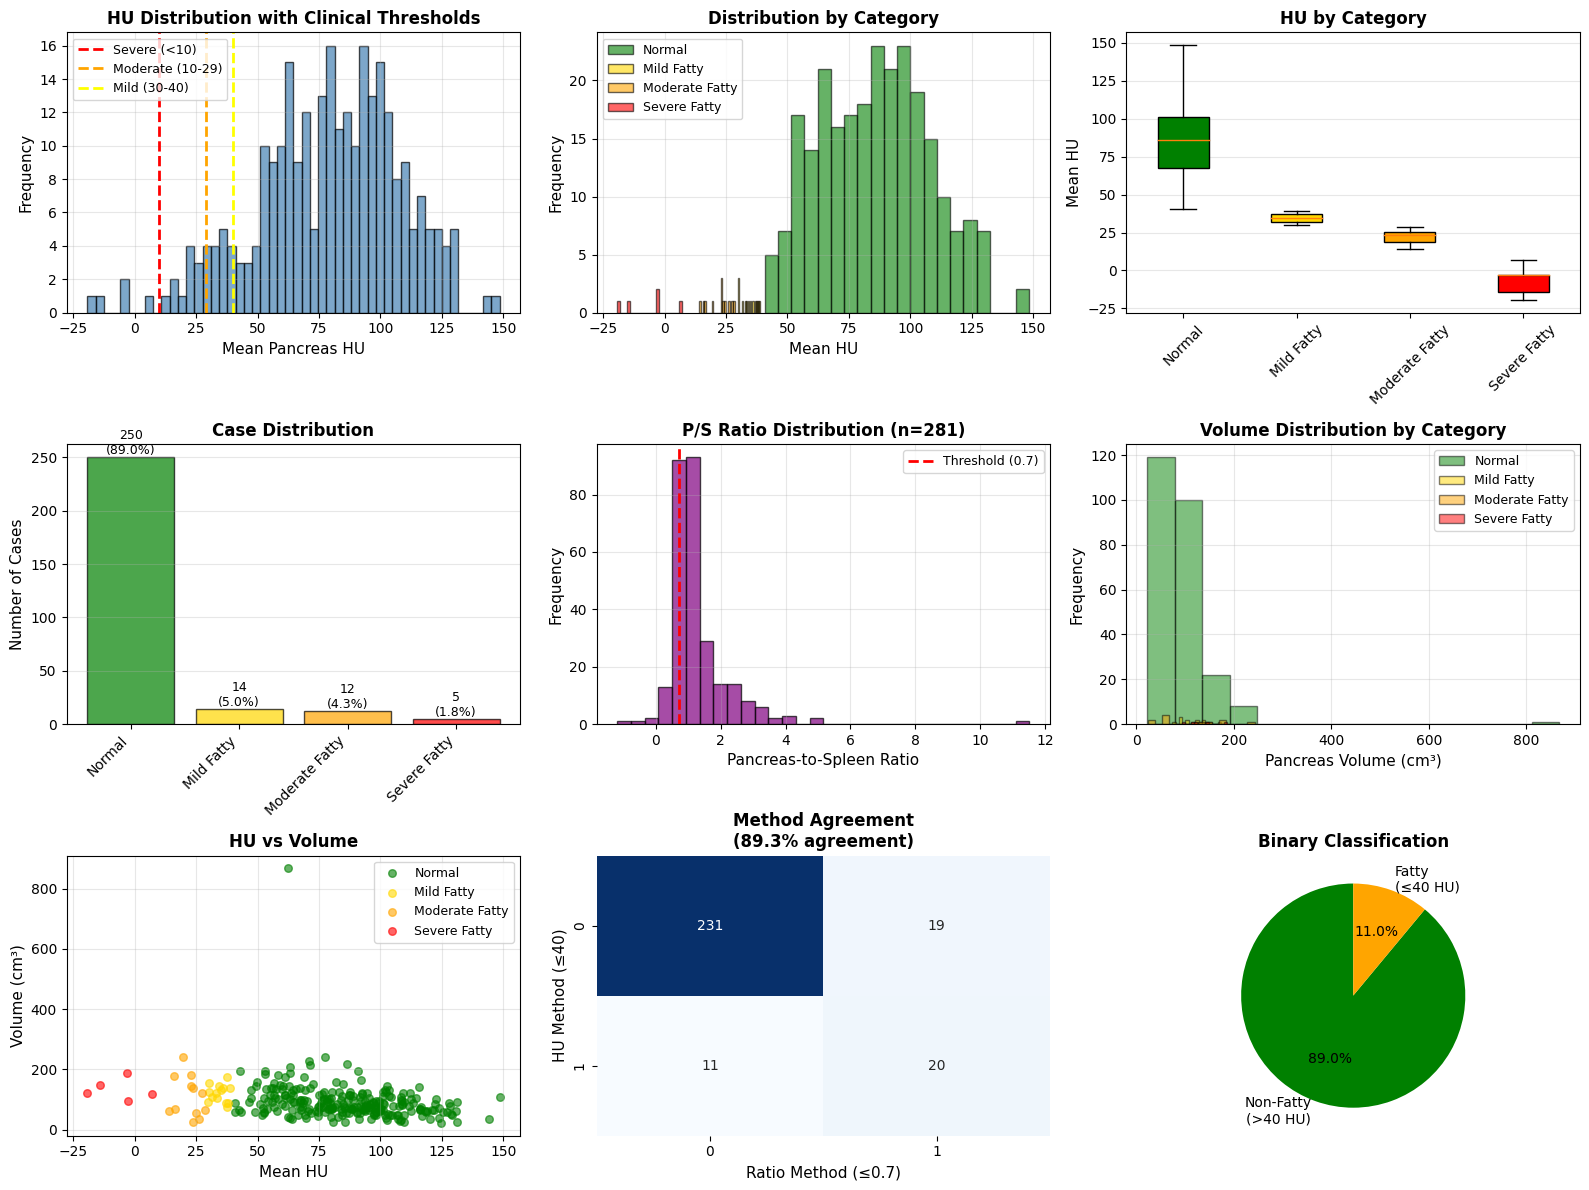

In [9]:
# ============================================================================
# VISUALIZATION
# ============================================================================

print("\n5. Generating visualizations...")

# Create comprehensive figure
fig = plt.figure(figsize=(16, 12))

# Plot 1: HU distribution with clinical thresholds
ax1 = plt.subplot(3, 3, 1)
ax1.hist(results_df['mean_hu'], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
ax1.axvline(THRESHOLDS['severe'], color='red', linestyle='--', linewidth=2, label='Severe (<10)')
ax1.axvline(THRESHOLDS['moderate'], color='orange', linestyle='--', linewidth=2, label='Moderate (10-29)')
ax1.axvline(THRESHOLDS['mild'], color='yellow', linestyle='--', linewidth=2, label='Mild (30-40)')
ax1.set_xlabel('Mean Pancreas HU', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('HU Distribution with Clinical Thresholds', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Category-wise distributions
ax2 = plt.subplot(3, 3, 2)
colors = {'Normal': 'green', 'Mild Fatty': 'gold', 'Moderate Fatty': 'orange', 'Severe Fatty': 'red'}
for cat in ['Normal', 'Mild Fatty', 'Moderate Fatty', 'Severe Fatty']:
    if cat in results_df['category'].values:
        data = results_df[results_df['category'] == cat]['mean_hu']
        ax2.hist(data, bins=20, alpha=0.6, label=cat, color=colors[cat], edgecolor='black')
ax2.set_xlabel('Mean HU', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Distribution by Category', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Box plot by category
ax3 = plt.subplot(3, 3, 3)
category_order = ['Normal', 'Mild Fatty', 'Moderate Fatty', 'Severe Fatty']
available_cats = [c for c in category_order if c in results_df['category'].values]
box_data = [results_df[results_df['category'] == cat]['mean_hu'] for cat in available_cats]
bp = ax3.boxplot(box_data, labels=available_cats, patch_artist=True)
for patch, cat in zip(bp['boxes'], available_cats):
    patch.set_facecolor(colors[cat])
ax3.set_ylabel('Mean HU', fontsize=11)
ax3.set_title('HU by Category', fontsize=12, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Category counts
ax4 = plt.subplot(3, 3, 4)
cat_counts = results_df['category'].value_counts()
cat_counts = cat_counts.reindex(category_order, fill_value=0)
bars = ax4.bar(range(len(cat_counts)), cat_counts.values, 
               color=[colors[c] for c in cat_counts.index], alpha=0.7, edgecolor='black')
ax4.set_xticks(range(len(cat_counts)))
ax4.set_xticklabels(cat_counts.index, rotation=45, ha='right')
ax4.set_ylabel('Number of Cases', fontsize=11)
ax4.set_title('Case Distribution', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({height/len(results_df)*100:.1f}%)',
                ha='center', va='bottom', fontsize=9)

# Plot 5: Pancreas-to-Spleen Ratio (if available)
ax5 = plt.subplot(3, 3, 5)
if spleen_found_count > 0:
    ratio_data = results_df[results_df['pancreas_spleen_ratio'].notna()]
    ax5.hist(ratio_data['pancreas_spleen_ratio'], bins=30, alpha=0.7, 
             edgecolor='black', color='purple')
    ax5.axvline(SPLEEN_RATIO_THRESHOLD, color='red', linestyle='--', 
                linewidth=2, label=f'Threshold ({SPLEEN_RATIO_THRESHOLD})')
    ax5.set_xlabel('Pancreas-to-Spleen Ratio', fontsize=11)
    ax5.set_ylabel('Frequency', fontsize=11)
    ax5.set_title(f'P/S Ratio Distribution (n={spleen_found_count})', 
                  fontsize=12, fontweight='bold')
    ax5.legend(fontsize=9)
    ax5.grid(True, alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'No Spleen Data\nAvailable', 
             ha='center', va='center', fontsize=12, transform=ax5.transAxes)
    ax5.axis('off')

# Plot 6: Volume distribution
ax6 = plt.subplot(3, 3, 6)
for cat in available_cats:
    data = results_df[results_df['category'] == cat]['volume_mm3'] / 1000  # Convert to cm³
    ax6.hist(data, bins=15, alpha=0.5, label=cat, color=colors[cat], edgecolor='black')
ax6.set_xlabel('Pancreas Volume (cm³)', fontsize=11)
ax6.set_ylabel('Frequency', fontsize=11)
ax6.set_title('Volume Distribution by Category', fontsize=12, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

# Plot 7: HU vs Volume scatter
ax7 = plt.subplot(3, 3, 7)
for cat in available_cats:
    data = results_df[results_df['category'] == cat]
    ax7.scatter(data['mean_hu'], data['volume_mm3']/1000, 
                alpha=0.6, label=cat, color=colors[cat], s=30)
ax7.set_xlabel('Mean HU', fontsize=11)
ax7.set_ylabel('Volume (cm³)', fontsize=11)
ax7.set_title('HU vs Volume', fontsize=12, fontweight='bold')
ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3)

# Plot 8: Agreement between methods (if spleen data exists)
ax8 = plt.subplot(3, 3, 8)
if spleen_found_count > 0:
    comparison_df = results_df[results_df['ratio_fatty'].notna()].copy()
    agreement = (comparison_df['is_fatty'] == comparison_df['ratio_fatty']).sum()
    agreement_pct = agreement / len(comparison_df) * 100
    
    confusion = pd.crosstab(comparison_df['is_fatty'], comparison_df['ratio_fatty'], 
                           rownames=['HU Method'], colnames=['Ratio Method'])
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', ax=ax8, cbar=False)
    ax8.set_title(f'Method Agreement\n({agreement_pct:.1f}% agreement)', 
                  fontsize=12, fontweight='bold')
    ax8.set_xlabel('Ratio Method (≤0.7)', fontsize=11)
    ax8.set_ylabel('HU Method (≤40)', fontsize=11)
else:
    ax8.text(0.5, 0.5, 'No Spleen Data\nfor Comparison', 
             ha='center', va='center', fontsize=12, transform=ax8.transAxes)
    ax8.axis('off')

# Plot 9: Summary pie chart
ax9 = plt.subplot(3, 3, 9)
binary_counts = results_df['is_fatty'].value_counts().sort_index()
labels = ['Non-Fatty\n(>40 HU)', 'Fatty\n(≤40 HU)']
ax9.pie(binary_counts, labels=labels, autopct='%1.1f%%', 
        colors=['green', 'orange'], startangle=90)
ax9.set_title('Binary Classification', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/clinical_classification_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


6. Training multi-class classification model...
   Training samples: 224
   Validation samples: 57

   Validation Accuracy: 0.982

   Classification Report:
                precision    recall  f1-score   support

        Normal       1.00      1.00      1.00        51
    Mild Fatty       1.00      1.00      1.00         3
Moderate Fatty       0.67      1.00      0.80         2
  Severe Fatty       0.00      0.00      0.00         1

      accuracy                           0.98        57
     macro avg       0.67      0.75      0.70        57
  weighted avg       0.97      0.98      0.98        57



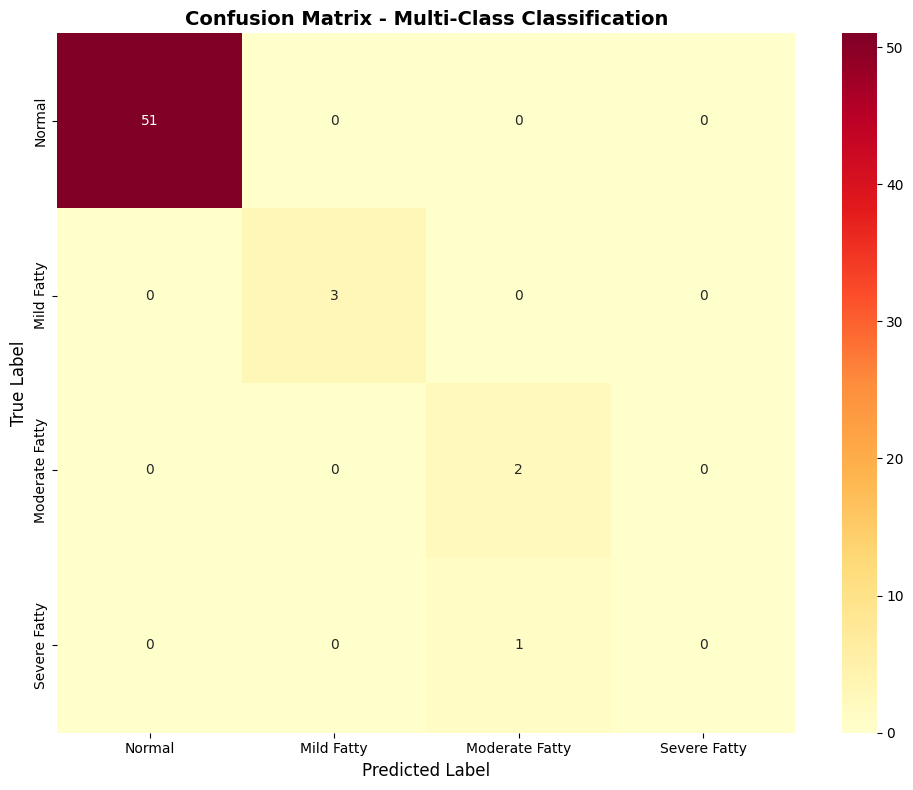


   Feature Importance:
   feature  importance
   mean_hu    0.543784
 median_hu    0.359919
volume_mm3    0.070768
    std_hu    0.025529


In [10]:
# ============================================================================
# MODEL TRAINING (MULTI-CLASS)
# ============================================================================

print("\n6. Training multi-class classification model...")

# Prepare features
feature_cols = ['mean_hu', 'std_hu', 'median_hu', 'volume_mm3']
X = results_df[feature_cols].values
y = results_df['label'].values  # 0=Normal, 1=Mild, 2=Moderate, 3=Severe

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"   Training samples: {len(X_train)}")
print(f"   Validation samples: {len(X_val)}")

# Train model
clf_multi = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

clf_multi.fit(X_train, y_train)

# Predictions
y_pred_val = clf_multi.predict(X_val)
val_acc = accuracy_score(y_val, y_pred_val)

print(f"\n   Validation Accuracy: {val_acc:.3f}")

print("\n   Classification Report:")
target_names = ['Normal', 'Mild Fatty', 'Moderate Fatty', 'Severe Fatty']
print(classification_report(y_val, y_pred_val, target_names=target_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Multi-Class Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix_multiclass.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': clf_multi.feature_importances_
}).sort_values('importance', ascending=False)

print("\n   Feature Importance:")
print(feature_importance.to_string(index=False))


In [11]:
# ============================================================================
# BINARY CLASSIFICATION (FATTY VS NON-FATTY)
# ============================================================================

print("\n7. Training binary classification model...")

X_binary = results_df[feature_cols].values
y_binary = results_df['is_fatty'].values

X_train_bin, X_val_bin, y_train_bin, y_val_bin = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=RANDOM_STATE, stratify=y_binary
)

clf_binary = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

clf_binary.fit(X_train_bin, y_train_bin)

y_pred_bin = clf_binary.predict(X_val_bin)
acc_bin = accuracy_score(y_val_bin, y_pred_bin)

print(f"   Binary Validation Accuracy: {acc_bin:.3f}")
print("\n   Binary Classification Report:")
print(classification_report(y_val_bin, y_pred_bin, 
                          target_names=['Non-Fatty', 'Fatty']))

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(clf_binary, X_binary, y_binary, cv=cv, scoring='accuracy')
print(f"\n   5-Fold CV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")



7. Training binary classification model...
   Binary Validation Accuracy: 1.000

   Binary Classification Report:
              precision    recall  f1-score   support

   Non-Fatty       1.00      1.00      1.00        51
       Fatty       1.00      1.00      1.00         6

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57


   5-Fold CV Accuracy: 1.000 ± 0.000


In [12]:
# ============================================================================
# SAVE RESULTS
# ============================================================================

print("\n8. Saving results...")

# Save labeled dataset
results_df.to_csv('/kaggle/working/pancreas_clinical_classification.csv', index=False)
print("   ✓ Saved: pancreas_clinical_classification.csv")

# Save models
joblib.dump(clf_multi, '/kaggle/working/multiclass_classifier.pkl')
joblib.dump(clf_binary, '/kaggle/working/binary_classifier.pkl')
print("   ✓ Saved: multiclass_classifier.pkl")
print("   ✓ Saved: binary_classifier.pkl")



8. Saving results...
   ✓ Saved: pancreas_clinical_classification.csv
   ✓ Saved: multiclass_classifier.pkl
   ✓ Saved: binary_classifier.pkl


In [13]:
# Save summary
summary = {
    'total_cases': len(results_df),
    'normal': (results_df['label']==0).sum(),
    'mild_fatty': (results_df['label']==1).sum(),
    'moderate_fatty': (results_df['label']==2).sum(),
    'severe_fatty': (results_df['label']==3).sum(),
    'spleen_cases': spleen_found_count,
    'multiclass_accuracy': val_acc,
    'binary_accuracy': acc_bin,
    'cv_accuracy_mean': cv_scores.mean(),
    'cv_accuracy_std': cv_scores.std()
}
pd.DataFrame([summary]).to_csv('/kaggle/working/classification_summary.csv', index=False)
print("   ✓ Saved: classification_summary.csv")

print("\n" + "="*80)
print("CLASSIFICATION COMPLETE!")
print("="*80)
print(f"Total cases: {len(results_df)}")
print(f"  - Normal (>40 HU):           {summary['normal']:4d} ({summary['normal']/len(results_df)*100:5.1f}%)")
print(f"  - Mild Fatty (30-40 HU):     {summary['mild_fatty']:4d} ({summary['mild_fatty']/len(results_df)*100:5.1f}%)")
print(f"  - Moderate Fatty (10-29 HU): {summary['moderate_fatty']:4d} ({summary['moderate_fatty']/len(results_df)*100:5.1f}%)")
print(f"  - Severe Fatty (<10 HU):     {summary['severe_fatty']:4d} ({summary['severe_fatty']/len(results_df)*100:5.1f}%)")
print(f"\nMulti-class Accuracy: {val_acc:.3f}")
print(f"Binary Accuracy: {acc_bin:.3f}")
print(f"Cross-validation: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
if spleen_found_count > 0:
    print(f"\nPancreas-to-Spleen ratio available for {spleen_found_count} cases")
print("="*80)

   ✓ Saved: classification_summary.csv

CLASSIFICATION COMPLETE!
Total cases: 281
  - Normal (>40 HU):            250 ( 89.0%)
  - Mild Fatty (30-40 HU):       14 (  5.0%)
  - Moderate Fatty (10-29 HU):   12 (  4.3%)
  - Severe Fatty (<10 HU):        5 (  1.8%)

Multi-class Accuracy: 0.982
Binary Accuracy: 1.000
Cross-validation: 1.000 ± 0.000

Pancreas-to-Spleen ratio available for 281 cases
